In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy
import random
import os
import time
import math
from math import sqrt

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import statsmodels.api as sm

import copy
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is:",device)

device is: cuda


In [3]:
SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
def metric(y_test, y_hat, log=False):
    MSE  = mean_squared_error(y_test, y_hat)
    RMSE = sqrt(MSE)
    MAE  = mean_absolute_error(y_test, y_hat)
    MAPE = mean_absolute_percentage_error(y_test, y_hat)
    R2   = r2_score(y_test, y_hat)
    
    if log:
        print(f'\
MSE...............{MSE:.4f}\n\
RMSE..............{RMSE:.4f}\n\
MAE...............{MAE:.4f}\n\
MAPE..............{MAPE:.4f}\n\
R2................{R2:.4f}\
              ')
    
    return [MSE, RMSE, MAE, MAPE, R2]

In [63]:
# # # отсчет времени # # #

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# # # подготовка данных # # #

def sliding_window(ts, features, shift=1, step_size=1):
    X, Y = [], []
    for i in range(features + 1, len(ts) + 1 - shift, step_size):
        X.append(ts[i - (features + 1):i - 1])
        Y.append([ts[i - 1 + shift]])
    return np.array(X), np.array(Y)


def lagging_var(data, var, lags_list):
    lagged_df = data.copy()
    for name, lags in zip(var, lags_list):
        for lag in lags:
            if lag > 0: 
                lagged_df[name + '_L' + str(lag)] = lagged_df[name].shift(lag)
    lagged_df = lagged_df.fillna(0)
    return lagged_df

def unscale(data, dim, scaler):
    trainPredict_dataset_like = np.zeros(shape=(len(data), dim))
    trainPredict_dataset_like[:,0] = data[:,0]
    trainPredict = scaler.inverse_transform(trainPredict_dataset_like)[:,0]
    return trainPredict

test = np.arange(0,100)
x,y = sliding_window(ts=test, features=24, shift=24, step_size=24)
print('x1=',x[0])
print('y1=',y[0])
print('x2=',x[1])
print('y2=',y[1])

x1= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
y1= [48]
x2= [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
y2= [72]


In [160]:
# загрузка датасета
file_name = 'experiment_rsv'

df = pd.read_pickle(f"DATASET\\{file_name}.pkl")
    
df = df.drop(columns=['load_actual_sobr', 'generate_actual_sobr', 'rsv', 'price']).dropna()

decomposition = sm.tsa.seasonal_decompose(df['ats'], model = 'additive', period=24)
df['ats_trend'] = decomposition.trend
df['ats_resid'] = decomposition.resid
df['ats_deseasonal'] = decomposition.resid + decomposition.trend

df = df.dropna()
df

,ats,month,day,day_of_week,year,index,workday,weekend,shortday,holiday,T2M,load_planned_sobr,generate_planned_sobr,ats_trend,ats_resid,ats_deseasonal
2014-01-01 12:00:00,721.739990,1.0,1.0,2.0,2014.0,12.0,0.0,0.0,0.0,1.0,-10.520000,3611.000000,2230.000000,727.971451,-29.348569,698.622882
2014-01-01 13:00:00,721.849976,1.0,1.0,2.0,2014.0,13.0,0.0,0.0,0.0,1.0,-10.420000,3744.000000,2280.000000,728.814575,-57.031893,671.782682
2014-01-01 14:00:00,721.299988,1.0,1.0,2.0,2014.0,14.0,0.0,0.0,0.0,1.0,-10.380000,3796.000000,2286.000000,729.812908,-74.402760,655.410149
2014-01-01 15:00:00,723.299988,1.0,1.0,2.0,2014.0,15.0,0.0,0.0,0.0,1.0,-10.420000,3823.000000,2286.000000,731.052076,-81.726192,649.325884
2014-01-01 16:00:00,752.739990,1.0,1.0,2.0,2014.0,16.0,0.0,0.0,0.0,1.0,-10.660000,3815.000000,2307.000000,732.312702,-51.198802,681.113900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 07:00:00,1365.060059,7.0,31.0,6.0,2022.0,72991.0,0.0,1.0,0.0,0.0,25.469999,3309.607910,2070.899902,1332.619596,-17.626831,1314.992765
2022-07-31 08:00:00,1455.150024,7.0,31.0,6.0,2022.0,72992.0,0.0,1.0,0.0,0.0,25.190001,3288.101074,2100.899902,1337.353971,51.906214,1389.260185
2022-07-31 09:00:00,1459.770020,7.0,31.0,6.0,2022.0,72993.0,0.0,1.0,0.0,0.0,24.820000,3295.981934,2105.899902,1341.762304,44.033612,1385.795916
2022-07-31 10:00:00,1460.359985,7.0,31.0,6.0,2022.0,72994.0,0.0,1.0,0.0,0.0,24.740000,3309.827881,2110.899902,1346.180219,42.553676,1388.733895


In [161]:
src = df[['ats_trend', 'T2M', 'load_planned_sobr', 'generate_planned_sobr']].copy().resample('D').mean().rolling(30).mean().dropna()
src = pd.merge(src, df[['month', 'day', 'day_of_week','year','workday','weekend','shortday','holiday']], how='outer', left_index=True, right_index=True).dropna()
src

,ats_trend,T2M,load_planned_sobr,generate_planned_sobr,month,day,day_of_week,year,workday,weekend,shortday,holiday
2014-01-30,717.417660,-17.995472,3959.390267,2508.893058,1.0,30.0,3.0,2014.0,1.0,0.0,0.0,0.0
2014-01-31,716.554202,-18.824778,3977.873608,2523.212500,1.0,31.0,4.0,2014.0,1.0,0.0,0.0,0.0
2014-02-01,715.324358,-19.395167,3993.669442,2539.298608,2.0,1.0,5.0,2014.0,0.0,1.0,0.0,0.0
2014-02-02,714.780475,-20.179375,4006.926383,2552.318050,2.0,2.0,6.0,2014.0,0.0,1.0,0.0,0.0
2014-02-03,715.436552,-20.350000,4021.656934,2565.797217,2.0,3.0,0.0,2014.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-27,1225.610176,16.595778,3211.994824,2025.129549,7.0,27.0,2.0,2022.0,1.0,0.0,0.0,0.0
2022-07-28,1231.300075,16.722000,3215.306738,2023.855314,7.0,28.0,3.0,2022.0,1.0,0.0,0.0,0.0
2022-07-29,1239.420134,16.772708,3217.583716,2020.972180,7.0,29.0,4.0,2022.0,1.0,0.0,0.0,0.0
2022-07-30,1248.296017,16.988083,3216.682845,2016.628691,7.0,30.0,5.0,2022.0,0.0,1.0,0.0,0.0


In [8]:
class RNN(nn.Module):

    def __init__(self, hidden_size, RNN_cell, in_size=1, out_size=1, bidirectional=False, dropout=0, num_layers=1):
        super(RNN, self).__init__()
        
        self.lstm = RNN_cell(input_size=in_size, 
                             hidden_size=hidden_size, 
                             batch_first=True, 
                             bidirectional=bidirectional,
                             num_layers=num_layers)
        n = 2 if bidirectional else 1
        self.fc      = nn.Linear(hidden_size*n, out_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, h=None):
        out, h = self.lstm(x, h)
        out = self.dropout(out)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out, h

In [9]:
def train(num_epochs, model, dataset_train, dataset_val, optimizer, criterion, scaler, feature_dim, step_size,
          iter_log=10, show_plot=False, lr_scheduler=None, patience=200, one_line_log=False):
    start = time.time()
    train_loss_list, val_loss_list = [], []
    best_loss, best_acc = 999, 999
    no_improvement, no_increase = 0, 0
    early_stopping_increment = 1
    prev_test_loss = 999
    
    try:
        for epoch in range(1, num_epochs+1):
            model.train()
            train_loss = .0
            yhat, yact = [], []
            for x, y in dataset_train:
                y_pred, _ = model(x.to(device)) 
                loss = criterion(y_pred, y.to(device))
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                train_loss += loss.item()
                yhat.append(y_pred.detach().cpu())
                yact.append(y.detach().cpu())
            yhat = [element.tolist() for sublist in yhat for element in sublist]
            yact = [element.tolist() for sublist in yact for element in sublist]
            train_acc = metric(unscale(np.array(yact), feature_dim, scaler), 
                               unscale(np.array(yhat), feature_dim, scaler))[1] #RMSE
            train_loss_list.append(train_loss)

            model.eval()
            test_loss = .0
            yhat, yact = [], []
            with torch.no_grad():
                for x, y in dataset_val:
                    y_pred, _ = model(x.to(device))
                    vall_loss = criterion(y_pred, y.to(device))
                    test_loss += vall_loss.item()
                    yhat.append(y_pred.detach().cpu())
                    yact.append(y.detach().cpu())
                yhat = [element.tolist() for sublist in yhat for element in sublist]
                yact = [element.tolist() for sublist in yact for element in sublist]
                test_acc = metric(unscale(np.array(yact), feature_dim, scaler), 
                                  unscale(np.array(yhat), feature_dim, scaler))[1] #RMSE
                val_loss_list.append(test_loss)
                
                lr_scheduler.step(test_loss)

            if (epoch > 1) and val_loss_list[-2] < val_loss_list[-1]:
                no_increase += 1
            else:
                no_increase = 0
            
            if no_increase < 20:
                early_stopping_increment = 1
            elif no_increase < 40:
                early_stopping_increment = 2
            else:
                early_stopping_increment = 3
            
            if test_loss < best_loss:
                best_loss = test_loss
                best_model = copy.deepcopy(model.state_dict())
                no_improvement -= 10
                no_improvement = 0 if no_improvement < 0 else no_improvement
            else:
                no_improvement += early_stopping_increment
            
            if test_acc < best_acc:
                best_acc  = test_acc
                                            
            if epoch % iter_log == 0:
                if one_line_log:
                    print(f"Epoch: {epoch}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, test acc: {test_acc:.2f}, best acc: {best_acc:.2f}, time: {timeSince(start, epoch/num_epochs)}, no improv.: {no_improvement}", end="")
                    print("\r", end="")
                else:
                    print(f"Epoch: {epoch}, train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, test acc: {test_acc:.2f}, best acc: {best_acc:.2f}, time: {timeSince(start, epoch/num_epochs)}, no improv.: {no_improvement}")
                                   
            if no_improvement >= patience:
                print(f'Early stop at {epoch} epoch')
                break
        
    except KeyboardInterrupt:
        print(f'Interrupted at {epoch} epoch')
        
    model.load_state_dict(best_model)
    
    if show_plot:
        plt.plot(train_loss_list[10:], c='tab:blue')
        plt.gca().twinx().plot(val_loss_list[10:], label='val', c='tab:red')
        plt.title(f'best acc - {best_acc:.4f}, best loss - {best_loss:.4f}')
        plt.legend()
        plt.show()
    
    return model


def batch_predict(model, dataloader):
    model.eval()
    yhat, yact = [], []
    with torch.no_grad():
        for x, y in dataloader:
            y_pred, _ = model(x.to(device))
            yhat.append(y_pred.detach().cpu())
            yact.append(y.detach().cpu())
        yhat = [element.tolist() for sublist in yhat for element in sublist]
        yact = [element.tolist() for sublist in yact for element in sublist]
    return np.array(yact), np.array(yhat)

In [141]:
def eval_metrics(model, val_loader, test_loader, scaler, 
                 iter_name=None, plot_val=False, plot_test=False, print_scores=False,
                 return_forecast=False):
    model.eval()
    yact, yhat = [], []
    with torch.no_grad():
        for x, y in val_loader:
            y_pred, _ = model(x.to(device))
            yhat.append(y_pred.detach().cpu())
            yact.append(y.detach().cpu())        
    yhat = [element.tolist() for sublist in yhat for element in sublist]
    yact = [element.tolist() for sublist in yact for element in sublist]
    yhat = unscale(np.array(yhat), x.shape[2], scaler)
    yact = unscale(np.array(yact), x.shape[2], scaler)

    if plot_test:
        plt.figure(figsize=(18,4))
        plt.plot(yhat, label='forecast')
        plt.plot(yact, label='actual')
        plt.title(f'VALIDATION {iter_name}')
        plt.legend()
        plt.show()

    metrics_val = metric(yact, yhat, log=print_scores)

    # # # #

    model.eval()
    yact, yhat = [], []
    with torch.no_grad():
        for x, y in test_loader:
            y_pred, _ = model(x.to(device))
            yhat.append(y_pred.detach().cpu())
            yact.append(y.detach().cpu())
            
    yhat = [element.tolist() for sublist in yhat for element in sublist]
    yact = [element.tolist() for sublist in yact for element in sublist]
    yhat = unscale(np.array(yhat), x.shape[2], scaler)
    yact = unscale(np.array(yact), x.shape[2], scaler)
    
    if plot_test:
        plt.figure(figsize=(18,4))
        plt.plot(yhat, label='forecast')
        plt.plot(yact, label='actual')
        plt.title(f'TEST {iter_name}')
        plt.legend()
        plt.show()

    metrics_test = metric(yact, yhat, log=print_scores)
    
    if not return_forecast:
        return metrics_val, metrics_test
    else:
        return metrics_val, metrics_test, yact, yhat

In [120]:
def data_prep(features, val_len=0.2, test_len=720, seq_length=720, shift=1, step_size=1, batch_size=256, print_shapes=False):
    data = features.copy().to_numpy()
    test_len += seq_length + shift

    train_val_data = data[:len(data) - test_len]
    test_data      = data[len(data) - test_len:]
    train_data     = train_val_data[:int(len(train_val_data)*(1-val_len))]
    val_data       = train_val_data[int(len(train_val_data)*(1-val_len)):]

    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(train_val_data)
    train_data = scaler.transform(train_data)
    test_data  = scaler.transform(test_data)
    val_data   = scaler.transform(val_data)

    X_train, y_train = sliding_window(train_data, seq_length, shift, step_size)
    X_val, y_val     = sliding_window(val_data, seq_length, shift, step_size)
    X_test, y_test   = sliding_window(test_data, seq_length, shift, step_size)

    dataset_train = DataLoader(TensorDataset(torch.Tensor(X_train), 
                                             torch.Tensor(y_train)[:,:,0]), 
                               batch_size=batch_size, shuffle=False)
    dataset_val  = DataLoader(TensorDataset(torch.Tensor(X_val),  
                                            torch.Tensor(y_val)[:,:,0]),  
                              batch_size=batch_size, shuffle=False)
    dataset_test  = DataLoader(TensorDataset(torch.Tensor(X_test),  
                                            torch.Tensor(y_test)[:,:,0]),  
                              batch_size=batch_size, shuffle=False)
    
    feature_dim = X_train.shape[2]
    
    if print_shapes:
        print('Train data shape:')
        print(f'X_train -> {X_train.shape}')
        print(f'y_train -> {y_train.shape}')
        print('Val data shape:')
        print(f'X_val -> {X_val.shape}')
        print(f'y_val -> {y_val.shape}')
        print('Test data shape:')
        print(f'X_test -> {X_test.shape}')
        print(f'y_test -> {y_test.shape}')
        
    return dataset_train, dataset_val, dataset_test, scaler, feature_dim

In [123]:
dataset_train, dataset_val, dataset_test, scaler, feature_dim = data_prep(features=df[['ats']], 
                                                                          val_len=0.2, 
                                                                          test_len=720, 
                                                                          seq_length=720, 
                                                                          shift=720, 
                                                                          step_size=24,
                                                                          batch_size=256,
                                                                          print_shapes=True)

Train data shape:
X_train -> (2300, 720, 1)
y_train -> (2300, 1, 1)
Val data shape:
X_val -> (530, 720, 1)
y_val -> (530, 1, 1)
Test data shape:
X_test -> (30, 720, 1)
y_test -> (30, 1, 1)


### Один запуск

Train data shape:
X_train -> (2105, 85, 3)
y_train -> (2105, 1, 3)
Val data shape:
X_val -> (440, 85, 3)
y_val -> (440, 1, 3)
Test data shape:
X_test -> (30, 85, 3)
y_test -> (30, 1, 3)
Early stop at 557 epoch 0.1913, test loss: 0.1845, test acc: 90.08, best acc: 61.68, time: 0m 33s (- 4m 31s), no improv.: 200


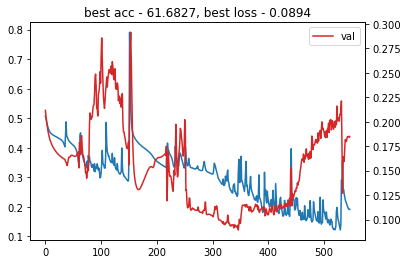

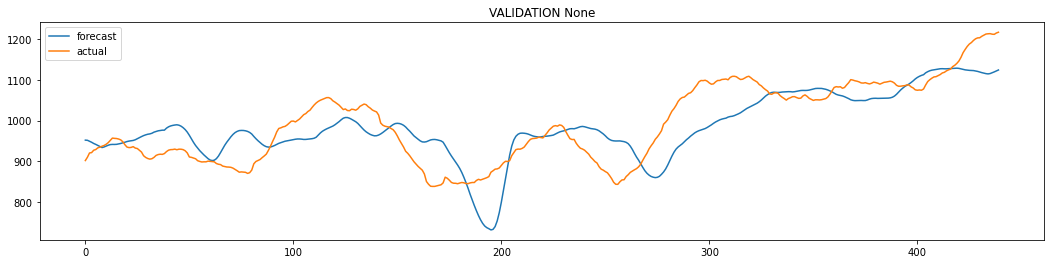

MSE...............3804.7497
RMSE..............61.6827
MAE...............50.5965
MAPE..............0.0520
R2................0.5884              


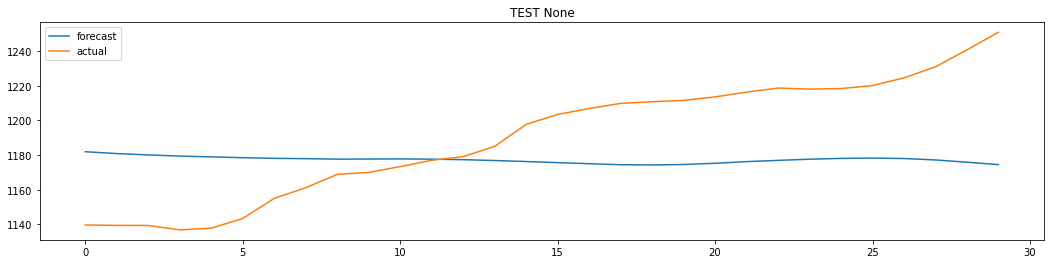

MSE...............1401.0194
RMSE..............37.4302
MAE...............32.9487
MAPE..............0.0275
R2................-0.2227              


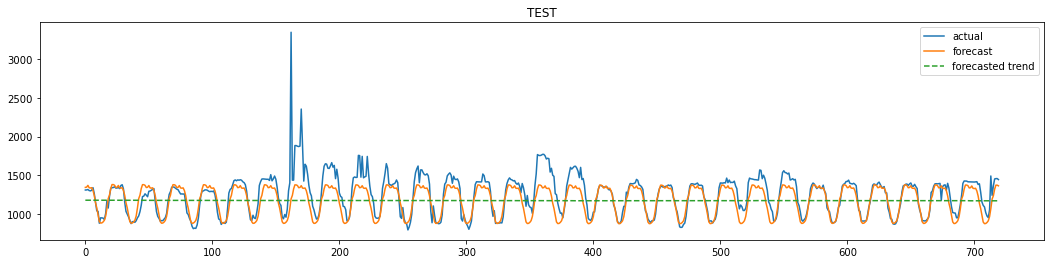

MSE...............26894.3846
RMSE..............163.9951
MAE...............102.3024
MAPE..............0.0757
R2................0.5674              


In [195]:
test_len = 30
rol = 31 #31

src = df[['ats_trend', 'T2M', 'load_planned_sobr', 'generate_planned_sobr']].copy().resample('D').mean().rolling(rol).mean().dropna()
src = pd.merge(src, df[['month', 'day', 'day_of_week','year','workday','weekend','shortday','holiday']], how='outer', left_index=True, right_index=True).dropna()
features = lagging_var(data=src, 
                   var=['ats_trend'], 
                   lags_list=[range(1,60)])
    
features = lagging_var(data=src, 
                       var=['ats_trend'], 
                       lags_list=[range(1,60)])

dataset_train, dataset_val, dataset_test, scaler, feature_dim = data_prep(features=features[['ats_trend', 'year', 'ats_trend_L53']], 
                                                                              val_len=0.2, 
                                                                              test_len=test_len, 
                                                                              seq_length=85, 
                                                                              shift=test_len, 
                                                                              batch_size=256,
                                                                              print_shapes=True)

seed_everything(SEED)
num_epochs    = 5000
learning_rate = 0.001
pat = 200
iter_log = 1
show_plot = True

model = RNN(RNN_cell=nn.LSTM,
            hidden_size=24,
            num_layers=1,
            dropout=0,
            in_size=feature_dim, 
            out_size=1, 
            bidirectional=False).to(device)

criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=9999, min_lr=1e-5)

best_model = copy.deepcopy(model.state_dict())

model = train(num_epochs=num_epochs, model=model, dataset_train=dataset_train, 
              dataset_val=dataset_val, optimizer=optimizer, criterion=criterion,
              lr_scheduler=lr_scheduler, patience=pat, scaler=scaler, feature_dim=feature_dim,
              iter_log=iter_log, show_plot=show_plot, step_size=None, one_line_log=True)

metrics_val, metrics_test, yact, yhat = eval_metrics(model=model, 
                                                     val_loader=dataset_val, 
                                                     test_loader=dataset_test,
                                                     scaler=scaler, 
                                                     iter_name=None, 
                                                     plot_val=True, 
                                                     plot_test=True, 
                                                     print_scores=True,
                                                     return_forecast=True)

decomposition = sm.tsa.seasonal_decompose(df['ats'].iloc[-test_len*2*24:-test_len*24], model = 'additive', period=24)
yact = df['ats'].iloc[-test_len*24:].values
yhat_trend = pd.DataFrame(np.repeat(yhat, 24, axis=0))
yhat = yhat_trend + decomposition.seasonal.values.reshape(-1,1)
plt.figure(figsize=(18,4))
plt.plot(yact, label='actual')
plt.plot(yhat, label='forecast')
plt.plot(yhat_trend, ls='--', label='forecasted trend')
plt.legend()
plt.title(f'TEST')
plt.show()
metric(yact, yhat, log=True);

In [209]:
pd.DataFrame({'yact' : yact.tolist(), 'yhat' : yhat.values.squeeze(1)}).to_pickle(f"DATASET\\LSTM_trend.pkl")

Train data shape:
X_train -> (4531, 336, 1)
y_train -> (4531, 1, 1)
Val data shape:
X_val -> (341, 336, 1)
y_val -> (341, 1, 1)
Test data shape:
X_test -> (720, 336, 1)
y_test -> (720, 1, 1)
Early stop at 254 epoch 0.2350, test loss: 0.0323, test acc: 82.53, best acc: 75.06, time: 0m 48s (- 15m 3s), no improv.: 2002


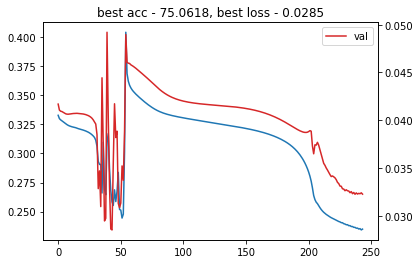

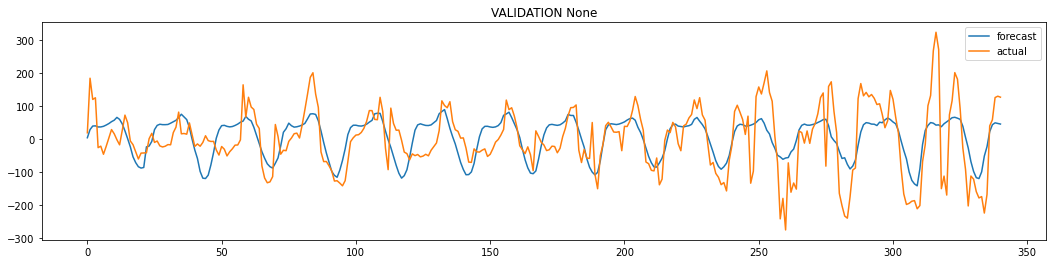

MSE...............5634.2786
RMSE..............75.0618
MAE...............59.6203
MAPE..............2.0621
R2................0.3853              


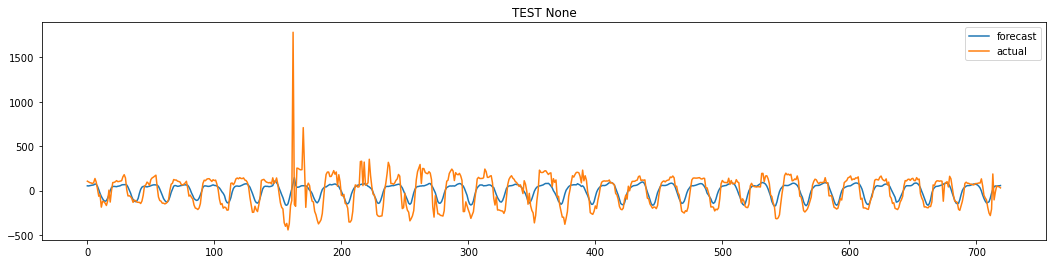

MSE...............15833.4909
RMSE..............125.8312
MAE...............86.8264
MAPE..............0.7477
R2................0.4713              


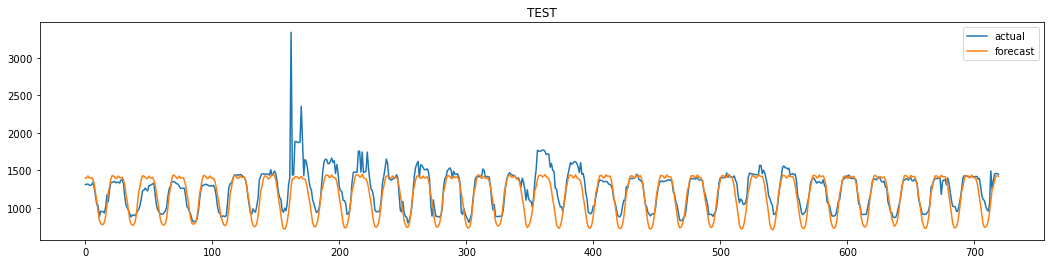

MSE...............30177.3337
RMSE..............173.7162
MAE...............118.3479
MAPE..............0.0963
R2................0.5146              


In [192]:
test_len = 720

dataset_train, dataset_val, dataset_test, scaler, feature_dim = data_prep(features=df[['ats_resid']].iloc[-365*24:], 
                                                                              val_len=0.2, 
                                                                              test_len=test_len, 
                                                                              seq_length=336, 
                                                                              shift=test_len, 
                                                                              batch_size=256,
                                                                              print_shapes=True)

seed_everything(SEED)
num_epochs    = 5000
learning_rate = 0.001
pat = 200
iter_log = 1
show_plot = True

model = RNN(RNN_cell=nn.LSTM,
            hidden_size=24,
            num_layers=1,
            dropout=0,
            in_size=feature_dim, 
            out_size=1, 
            bidirectional=False).to(device)

criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=9999, min_lr=1e-5)

best_model = copy.deepcopy(model.state_dict())

model = train(num_epochs=num_epochs, model=model, dataset_train=dataset_train, 
              dataset_val=dataset_val, optimizer=optimizer, criterion=criterion,
              lr_scheduler=lr_scheduler, patience=pat, scaler=scaler, feature_dim=feature_dim,
              iter_log=iter_log, show_plot=show_plot, step_size=None, one_line_log=True)

# # #

metrics_val, metrics_test, yact, yhat = eval_metrics(model=model, 
                                                     val_loader=dataset_val, 
                                                     test_loader=dataset_test,
                                                     scaler=scaler, 
                                                     iter_name=None, 
                                                     plot_val=True, 
                                                     plot_test=True, 
                                                     print_scores=True,
                                                     return_forecast=True)

decomposition = sm.tsa.seasonal_decompose(df['ats'].iloc[-test_len*2:-test_len], model = 'additive', period=24)
yact = df['ats'].iloc[-test_len:].values
yhat += yhat_trend.values.squeeze(1) + decomposition.seasonal.values
plt.figure(figsize=(18,4))
plt.plot(yact, label='actual')
plt.plot(yhat, label='forecast')
plt.legend()
plt.title(f'TEST')
plt.show()
metric(yact, yhat, log=True);

In [23]:
pd.DataFrame({'yact' : y_act, 'yhat' : y_hat}).to_pickle(f"DATASET\\LSTM.pkl")

### Итерировать по seq_len

In [173]:
seq_len = range(1,30*4)

val_results, test_results = {}, {}

features = lagging_var(data=src, 
                       var=['ats_trend'], 
                       lags_list=[range(1,60)])

for seq_length in seq_len:
    iter_name = f'seq_len->{seq_length}'
    print(iter_name)
    
    dataset_train, dataset_val, dataset_test, scaler, feature_dim = data_prep(features=features[['ats_trend', 'year', 'ats_trend_L53']], 
                                                                              val_len=0.2, 
                                                                              test_len=30, 
                                                                              seq_length=seq_length, 
                                                                              shift=30, 
                                                                              batch_size=256,
                                                                              print_shapes=False)

    seed_everything(SEED)
    num_epochs    = 5000
    learning_rate = 1e-3
    pat = 200

    model = RNN(RNN_cell=nn.LSTM,
                hidden_size=24,
                num_layers=1,
                dropout=0,
                in_size=feature_dim, 
                out_size=1, 
                bidirectional=False).to(device)

    criterion = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=9999, min_lr=1e-5)

    best_model = copy.deepcopy(model.state_dict())

    model = train(num_epochs=num_epochs, model=model, dataset_train=dataset_train, 
                  dataset_val=dataset_val, optimizer=optimizer, criterion=criterion,
                  lr_scheduler=lr_scheduler, patience=pat, scaler=scaler, feature_dim=feature_dim,
                  iter_log=1, show_plot=False, step_size=None, one_line_log=True)

    metrics_val, metrics_test, yact, yhat = eval_metrics(model=model, 
                                                     val_loader=dataset_val, 
                                                     test_loader=dataset_test,
                                                     scaler=scaler, 
                                                     iter_name=None, 
                                                     plot_val=False, 
                                                     plot_test=False, 
                                                     print_scores=False,
                                                     return_forecast=True)

#     decomposition = sm.tsa.seasonal_decompose(df['ats'].iloc[-test_len*2*24:-test_len*24], model = 'additive', period=24)
#     yact = df['ats'].iloc[-test_len*24:].values
#     yhat_trend = pd.DataFrame(np.repeat(y_hat, 24, axis=0))
#     yhat = pd.DataFrame(np.repeat(y_hat, 24, axis=0)) + decomposition.seasonal.values.reshape(-1,1)
#     plt.figure(figsize=(18,4))
#     plt.plot(yact, label='actual')
#     plt.plot(yhat, label='forecast')
#     plt.plot(yhat_trend, ls='--', label='forecasted trend')
#     plt.legend()
#     plt.title(f'TEST')
#     plt.show()
#     metric(yact, yhat, log=True);
    
    val_results.update({iter_name : metrics_val})
    test_results.update({iter_name : metrics_test})

for key, value in val_results.items():
    print(key, '....', [round(x,2) for x in value])
print('Best: ', min(val_results, key=val_results.get), val_results[min(val_results, key=val_results.get)], '\n')
for key, value in test_results.items():
    print(key, '....', [round(x,2) for x in value])
print('Best: ', min(test_results, key=test_results.get), test_results[min(test_results, key=test_results.get)], '\n')

seq_len->1
Early stop at 422 epoch 0.3296, test loss: 0.1448, test acc: 87.02, best acc: 86.05, time: 0m 20s (- 3m 39s), no improv.: 200
seq_len->2
Early stop at 279 epoch 0.3317, test loss: 0.1486, test acc: 86.66, best acc: 85.61, time: 0m 12s (- 3m 30s), no improv.: 200
seq_len->3
Early stop at 244 epoch 0.3327, test loss: 0.1553, test acc: 87.78, best acc: 86.38, time: 0m 12s (- 3m 59s), no improv.: 200
seq_len->4
Early stop at 231 epoch 0.3329, test loss: 0.1594, test acc: 88.87, best acc: 87.26, time: 0m 11s (- 3m 59s), no improv.: 200
seq_len->5
Early stop at 226 epoch 0.3315, test loss: 0.1583, test acc: 89.20, best acc: 87.52, time: 0m 10s (- 3m 44s), no improv.: 200
seq_len->6
Early stop at 239 epoch 0.3089, test loss: 0.1614, test acc: 92.40, best acc: 88.77, time: 0m 10s (- 3m 35s), no improv.: 200
seq_len->7
Early stop at 277 epoch 0.2418, test loss: 0.1597, test acc: 92.52, best acc: 90.23, time: 0m 12s (- 3m 39s), no improv.: 2008
seq_len->8
Early stop at 341 epoch 0.281

Early stop at 238 epoch 0.3119, test loss: 0.3482, test acc: 91.54, best acc: 70.57, time: 0m 14s (- 4m 56s), no improv.: 200
seq_len->1 .... [7417.82, 86.13, 68.99, 0.07, 0.57]
seq_len->2 .... [7330.43, 85.62, 68.27, 0.07, 0.57]
seq_len->3 .... [7464.19, 86.4, 68.88, 0.07, 0.56]
seq_len->4 .... [7617.83, 87.28, 69.61, 0.07, 0.55]
seq_len->5 .... [7664.73, 87.55, 69.77, 0.07, 0.55]
seq_len->6 .... [7883.0, 88.79, 70.94, 0.07, 0.54]
seq_len->7 .... [8149.16, 90.27, 72.7, 0.07, 0.52]
seq_len->8 .... [8534.28, 92.38, 74.9, 0.07, 0.5]
seq_len->9 .... [7567.71, 86.99, 71.28, 0.07, 0.56]
seq_len->10 .... [6727.79, 82.02, 67.92, 0.07, 0.61]
seq_len->11 .... [5910.34, 76.88, 64.1, 0.06, 0.65]
seq_len->12 .... [5659.15, 75.23, 62.6, 0.06, 0.67]
seq_len->13 .... [5707.0, 75.54, 62.62, 0.06, 0.66]
seq_len->14 .... [5826.44, 76.33, 63.11, 0.06, 0.66]
seq_len->15 .... [5946.6, 77.11, 63.52, 0.06, 0.65]
seq_len->16 .... [6040.33, 77.72, 63.89, 0.06, 0.64]
seq_len->17 .... [6456.6, 80.35, 67.41, 0.07

### Итерировать по rolling.mean

In [188]:
rol_list = range(1,61)

val_results, test_results = {}, {}

for rol in rol_list:
    iter_name = f'rolling->{rol}'
    print(iter_name)
    
    src = df[['ats_trend', 'T2M', 'load_planned_sobr', 'generate_planned_sobr']].copy().resample('D').mean().rolling(rol).mean().dropna()
    src = pd.merge(src, df[['month', 'day', 'day_of_week','year','workday','weekend','shortday','holiday']], how='outer', left_index=True, right_index=True).dropna()
    features = lagging_var(data=src, 
                       var=['ats_trend'], 
                       lags_list=[range(1,60)])
    
    dataset_train, dataset_val, dataset_test, scaler, feature_dim = data_prep(features=features[['ats_trend', 'year', 'ats_trend_L53']], 
                                                                              val_len=0.2, 
                                                                              test_len=30, 
                                                                              seq_length=85, 
                                                                              shift=30, 
                                                                              batch_size=256,
                                                                              print_shapes=False)

    seed_everything(SEED)
    num_epochs    = 5000
    learning_rate = 1e-3
    pat = 200

    model = RNN(RNN_cell=nn.LSTM,
                hidden_size=24,
                num_layers=1,
                dropout=0,
                in_size=feature_dim, 
                out_size=1, 
                bidirectional=False).to(device)

    criterion = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=9999, min_lr=1e-5)

    best_model = copy.deepcopy(model.state_dict())

    model = train(num_epochs=num_epochs, model=model, dataset_train=dataset_train, 
                  dataset_val=dataset_val, optimizer=optimizer, criterion=criterion,
                  lr_scheduler=lr_scheduler, patience=pat, scaler=scaler, feature_dim=feature_dim,
                  iter_log=1, show_plot=False, step_size=None, one_line_log=True)

    metrics_val, metrics_test, yact, yhat = eval_metrics(model=model, 
                                                     val_loader=dataset_val, 
                                                     test_loader=dataset_test,
                                                     scaler=scaler, 
                                                     iter_name=None, 
                                                     plot_val=False, 
                                                     plot_test=False, 
                                                     print_scores=False,
                                                     return_forecast=True)
    
    val_results.update({iter_name : metrics_val})
    test_results.update({iter_name : metrics_test})

for key, value in val_results.items():
    print(key, '....', [round(x,2) for x in value])
print('Best: ', min(val_results, key=val_results.get), val_results[min(val_results, key=val_results.get)], '\n')
for key, value in test_results.items():
    print(key, '....', [round(x,2) for x in value])
print('Best: ', min(test_results, key=test_results.get), test_results[min(test_results, key=test_results.get)], '\n')

rolling->1
Early stop at 201 epoch 0.2276, test loss: 0.0698, test acc: 121.20, best acc: 119.58, time: 0m 12s (- 5m 2s), no improv.: 2005
rolling->2
Early stop at 254 epoch 0.2555, test loss: 0.0960, test acc: 120.69, best acc: 115.77, time: 0m 14s (- 4m 40s), no improv.: 200
rolling->3
Early stop at 217 epoch 0.2225, test loss: 0.0789, test acc: 112.42, best acc: 111.82, time: 0m 13s (- 5m 0s), no improv.: 200
rolling->4
Early stop at 290 epoch 0.2604, test loss: 0.1046, test acc: 116.26, best acc: 109.74, time: 0m 19s (- 5m 11s), no improv.: 200
rolling->5
Early stop at 363 epoch 0.2224, test loss: 0.1360, test acc: 122.49, best acc: 105.03, time: 0m 21s (- 4m 40s), no improv.: 200
rolling->6
Early stop at 317 epoch 0.2822, test loss: 0.1687, test acc: 127.87, best acc: 104.09, time: 0m 20s (- 5m 0s), no improv.: 2008
rolling->7
Early stop at 275 epoch 0.2975, test loss: 0.1762, test acc: 123.29, best acc: 102.52, time: 0m 17s (- 5m 6s), no improv.: 2003
rolling->8
Early stop at 379

### Итерирование по гиперпараметрам

In [176]:
val_results, test_results = {}, {}

features = lagging_var(data=src, 
                       var=['ats_trend'], 
                       lags_list=[range(1,60)])

dataset_train, dataset_val, dataset_test, scaler, feature_dim = data_prep(features=features[['ats_trend', 'year', 'ats_trend_L53']], 
                                                                              val_len=0.2, 
                                                                              test_len=30, 
                                                                              seq_length=85, 
                                                                              shift=30, 
                                                                              batch_size=256,
                                                                              print_shapes=False)


hd = [12, 24, 32, 64, 80]
lr = [1e-4, 3e-4, 1e-3]
dr = [0, .1, .2]

for hidden_size in hd:
    for learning_rate in lr:
        for dropout in dr:
            iter_name = f'hd->{hidden_size}, lr->{learning_rate}, dr->{dropout}'
            print(iter_name)

            seed_everything(SEED)
            num_epochs    = 5000
            learning_rate = learning_rate
            pat = 200

            model = RNN(RNN_cell=nn.LSTM,
                        hidden_size=hidden_size,
                        num_layers=1,
                        dropout=dropout,
                        in_size=feature_dim, 
                        out_size=1, 
                        bidirectional=False).to(device)

            criterion = torch.nn.MSELoss().to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
            lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=9999, min_lr=1e-5)

            best_model = copy.deepcopy(model.state_dict())

            model = train(num_epochs=num_epochs, model=model, dataset_train=dataset_train, 
                          dataset_val=dataset_val, optimizer=optimizer, criterion=criterion,
                          lr_scheduler=lr_scheduler, patience=pat, scaler=scaler, feature_dim=feature_dim,
                          iter_log=1, show_plot=False, step_size=None, one_line_log=True)

            metrics_val, metrics_test, yact, yhat = eval_metrics(model=model, 
                                                             val_loader=dataset_val, 
                                                             test_loader=dataset_test,
                                                             scaler=scaler, 
                                                             iter_name=None, 
                                                             plot_val=False, 
                                                             plot_test=False, 
                                                             print_scores=False,
                                                             return_forecast=True)

        #     decomposition = sm.tsa.seasonal_decompose(df['ats'].iloc[-test_len*2*24:-test_len*24], model = 'additive', period=24)
        #     yact = df['ats'].iloc[-test_len*24:].values
        #     yhat_trend = pd.DataFrame(np.repeat(y_hat, 24, axis=0))
        #     yhat = pd.DataFrame(np.repeat(y_hat, 24, axis=0)) + decomposition.seasonal.values.reshape(-1,1)
        #     plt.figure(figsize=(18,4))
        #     plt.plot(yact, label='actual')
        #     plt.plot(yhat, label='forecast')
        #     plt.plot(yhat_trend, ls='--', label='forecasted trend')
        #     plt.legend()
        #     plt.title(f'TEST')
        #     plt.show()
        #     metric(yact, yhat, log=True);

            val_results.update({iter_name : metrics_val})
            test_results.update({iter_name : metrics_test})

for key, value in val_results.items():
    print(key, '....', [round(x,2) for x in value])
print('Best: ', min(val_results, key=val_results.get), val_results[min(val_results, key=val_results.get)], '\n')
for key, value in test_results.items():
    print(key, '....', [round(x,2) for x in value])
print('Best: ', min(test_results, key=test_results.get), test_results[min(test_results, key=test_results.get)], '\n')

hd->12, lr->0.0001, dr->0
Early stop at 740 epoch 0.4291, test loss: 0.1842, test acc: 87.90, best acc: 87.78, time: 0m 44s (- 4m 15s), no improv.: 200
hd->12, lr->0.0001, dr->0.1
Early stop at 878 epoch 0.4370, test loss: 0.1857, test acc: 88.13, best acc: 87.81, time: 0m 53s (- 4m 12s), no improv.: 200
hd->12, lr->0.0001, dr->0.2
Early stop at 972 epoch 0.4369, test loss: 0.1859, test acc: 88.13, best acc: 87.82, time: 1m 0s (- 4m 12s), no improv.: 2006
hd->12, lr->0.0003, dr->0
Early stop at 290 epoch 0.4211, test loss: 0.1941, test acc: 89.75, best acc: 88.28, time: 0m 17s (- 4m 49s), no improv.: 200
hd->12, lr->0.0003, dr->0.1
Early stop at 386 epoch 0.4125, test loss: 0.2146, test acc: 93.53, best acc: 88.36, time: 0m 24s (- 4m 51s), no improv.: 201
hd->12, lr->0.0003, dr->0.2
Early stop at 436 epoch 0.4158, test loss: 0.2186, test acc: 94.25, best acc: 88.39, time: 0m 26s (- 4m 41s), no improv.: 201
hd->12, lr->0.001, dr->0
Early stop at 171 epoch 0.4059, test loss: 0.2769, test

### Feture selector

In [155]:
np.set_printoptions(formatter={'float_kind' : "{:.3f}".format})

def train_model(data):
    print(f'\n{data.columns=}')
    dataset_train, dataset_val, dataset_test, scaler, feature_dim = data_prep(features=data, 
                                                                              val_len=0.2, 
                                                                              test_len=test_len, 
                                                                              seq_length=60, 
                                                                              shift=test_len, 
                                                                              batch_size=256,
                                                                              print_shapes=False)

    seed_everything(SEED)
    num_epochs    = 5000
    learning_rate = 1e-3
    pat = 200

    model = RNN(RNN_cell=nn.LSTM,
                hidden_size=24,
                num_layers=1,
                dropout=0,
                in_size=feature_dim, 
                out_size=1, 
                bidirectional=False).to(device)

    criterion = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=9999, min_lr=1e-5)

    best_model = copy.deepcopy(model.state_dict())

    model = train(num_epochs=num_epochs, model=model, dataset_train=dataset_train, 
                  dataset_val=dataset_val, optimizer=optimizer, criterion=criterion,
                  lr_scheduler=lr_scheduler, patience=pat, scaler=scaler, feature_dim=feature_dim,
                  iter_log=1, show_plot=False, step_size=None, one_line_log=True)

    metrics_val, metrics_test, yact, yhat = eval_metrics(model=model, 
                                                         val_loader=dataset_val, 
                                                         test_loader=dataset_test,
                                                         scaler=scaler, 
                                                         iter_name=None, 
                                                         plot_val=False, 
                                                         plot_test=False, 
                                                         print_scores=False,
                                                         return_forecast=True)
    
    return model, metrics_val

def iterate(data):
    score = {}
    for i in main_features.columns:
        X = data.copy()
        X[i] = main_features[[i]]
        _, metrics = train_model(X)
        score.update({i : metrics[1]})
        results.loc[' + '.join(data.columns.tolist()), i] = metrics[1]
        print(f'....{i} -> RMSE={metrics[1]:.2f}')
    feature = min(score, key=score.get)
    print(f'Best feature - {feature}, metric improvment - {(score[feature]-prev_score):.3f} (acc = {score[feature]:.3f})')
    return feature, score[feature]

In [159]:
src.columns

Index(['T2M', 'load_planned_sobr', 'generate_planned_sobr', 'month', 'day',
       'day_of_week', 'year', 'workday', 'weekend', 'shortday', 'holiday'],
      dtype='object')

In [163]:
import warnings
warnings.filterwarnings('ignore')



main_features = lagging_var(data=src, 
                            var=['ats_trend'], 
                            lags_list=[range(1,60)])
data = pd.DataFrame(main_features.pop('ats_trend'))
# data = pd.concat([main_features.pop(x) for x in ['price_smooth', 'index']], axis=1)

_, init_score = train_model(data)
init_score = init_score[1]
prev_score = init_score
print(f'Initial score = {prev_score:.3f}')

results = pd.DataFrame()
results.loc[' + '.join(data.columns.tolist()), ' + '.join(data.columns.tolist())] = prev_score
epoch = len(main_features.columns)
hold = 0
for f in range(1,epoch+1):
    start = time.time()
    best_feature, best_score = iterate(data)
    if best_score < prev_score:
        hold = 0
        data[best_feature] = main_features.pop(best_feature)
        prev_score = best_score
        best_x = data.copy()
        print(f'add - {best_feature}\n')
    elif hold < 0:
        hold += 1
        data[best_feature] = main_features.pop(best_feature)
        print(f'negative add - {best_feature}\n')
    else:
        break
print('Picked features ->', [c for c in best_x.columns], '\n')
# # # # # # # # # # # # # # # # # # # # # #

_, metrics = train_model(best_x)

print(metrics)


data.columns=Index(['ats_trend'], dtype='object')
Early stop at 305 epoch 0.3137, test loss: 0.1805, test acc: 99.69, best acc: 85.59, time: 0m 16s (- 4m 12s), no improv.: 2001
Initial score = 85.593

data.columns=Index(['ats_trend', 'T2M'], dtype='object')
Early stop at 367 epoch 0.2266, test loss: 0.1462, test acc: 90.79, best acc: 78.95, time: 0m 20s (- 4m 21s), no improv.: 200
....T2M -> RMSE=78.95

data.columns=Index(['ats_trend', 'load_planned_sobr'], dtype='object')
Early stop at 412 epoch 0.1502, test loss: 0.1661, test acc: 96.75, best acc: 83.71, time: 0m 24s (- 4m 30s), no improv.: 200
....load_planned_sobr -> RMSE=83.71

data.columns=Index(['ats_trend', 'generate_planned_sobr'], dtype='object')
Early stop at 208 epoch 0.2846, test loss: 0.2679, test acc: 120.54, best acc: 102.76, time: 0m 11s (- 4m 17s), no improv.: 200
....generate_planned_sobr -> RMSE=102.76

data.columns=Index(['ats_trend', 'month'], dtype='object')
Early stop at 372 epoch 0.1671, test loss: 0.1644, tes

Early stop at 319 epoch 0.0750, test loss: 0.1441, test acc: 87.73, best acc: 74.37, time: 0m 20s (- 5m 0s), no improv.: 2001
....load_planned_sobr -> RMSE=74.37

data.columns=Index(['ats_trend', 'year', 'generate_planned_sobr'], dtype='object')
Early stop at 234 epoch 0.1402, test loss: 0.5345, test acc: 167.74, best acc: 96.01, time: 0m 18s (- 6m 19s), no improv.: 200
....generate_planned_sobr -> RMSE=96.01

data.columns=Index(['ats_trend', 'year', 'month'], dtype='object')
Early stop at 364 epoch 0.0765, test loss: 0.1758, test acc: 98.68, best acc: 79.61, time: 0m 25s (- 5m 19s), no improv.: 2002
....month -> RMSE=79.61

data.columns=Index(['ats_trend', 'year', 'day'], dtype='object')
Early stop at 328 epoch 0.1401, test loss: 0.2783, test acc: 121.74, best acc: 87.53, time: 0m 22s (- 5m 25s), no improv.: 200
....day -> RMSE=87.60

data.columns=Index(['ats_trend', 'year', 'day_of_week'], dtype='object')
Early stop at 314 epoch 0.1950, test loss: 0.1900, test acc: 100.56, best acc: 

Early stop at 289 epoch 0.0762, test loss: 0.1365, test acc: 85.82, best acc: 77.18, time: 0m 19s (- 5m 11s), no improv.: 200
....load_planned_sobr -> RMSE=77.18

data.columns=Index(['ats_trend', 'year', 'ats_trend_L53', 'generate_planned_sobr'], dtype='object')
Early stop at 248 epoch 0.0836, test loss: 0.5173, test acc: 164.70, best acc: 80.23, time: 0m 15s (- 5m 3s), no improv.: 2000
....generate_planned_sobr -> RMSE=80.23

data.columns=Index(['ats_trend', 'year', 'ats_trend_L53', 'month'], dtype='object')
Early stop at 279 epoch 0.0844, test loss: 0.1816, test acc: 98.88, best acc: 73.21, time: 0m 17s (- 4m 56s), no improv.: 2009
....month -> RMSE=73.21

data.columns=Index(['ats_trend', 'year', 'ats_trend_L53', 'day'], dtype='object')
Early stop at 455 epoch 0.1568, test loss: 0.1914, test acc: 100.75, best acc: 76.99, time: 0m 27s (- 4m 34s), no improv.: 200
....day -> RMSE=77.14

data.columns=Index(['ats_trend', 'year', 'ats_trend_L53', 'day_of_week'], dtype='object')
Early stop 

Early stop at 290 epoch 0.1626, test loss: 0.2485, test acc: 114.63, best acc: 75.20, time: 0m 18s (- 4m 52s), no improv.: 200
....ats_trend_L25 -> RMSE=75.20

data.columns=Index(['ats_trend', 'year', 'ats_trend_L53', 'ats_trend_L26'], dtype='object')
Early stop at 284 epoch 0.1545, test loss: 0.3537, test acc: 136.52, best acc: 80.25, time: 0m 16s (- 4m 41s), no improv.: 200
....ats_trend_L26 -> RMSE=80.25

data.columns=Index(['ats_trend', 'year', 'ats_trend_L53', 'ats_trend_L27'], dtype='object')
Early stop at 289 epoch 0.1535, test loss: 0.3824, test acc: 141.96, best acc: 79.09, time: 0m 17s (- 4m 42s), no improv.: 200
....ats_trend_L27 -> RMSE=79.09

data.columns=Index(['ats_trend', 'year', 'ats_trend_L53', 'ats_trend_L28'], dtype='object')
Early stop at 298 epoch 0.1259, test loss: 0.3350, test acc: 132.90, best acc: 75.27, time: 0m 17s (- 4m 41s), no improv.: 200
....ats_trend_L28 -> RMSE=75.27

data.columns=Index(['ats_trend', 'year', 'ats_trend_L53', 'ats_trend_L29'], dtype='o

Early stop at 279 epoch 0.2336, test loss: 0.1813, test acc: 98.51, best acc: 75.99, time: 0m 17s (- 4m 51s), no improv.: 2009
....ats_trend_L59 -> RMSE=75.99
Best feature - ats_trend_L54, metric improvment - 1.013 (acc = 63.209)
Picked features -> ['ats_trend', 'year', 'ats_trend_L53'] 


data.columns=Index(['ats_trend', 'year', 'ats_trend_L53'], dtype='object')
Early stop at 461 epoch 0.1412, test loss: 0.3530, test acc: 136.24, best acc: 62.20, time: 0m 25s (- 4m 13s), no improv.: 200
[3868.3489384374775, 62.19605243451932, 49.70738235134638, 0.04956811141544706, 0.6939905096691052]


<AxesSubplot:>

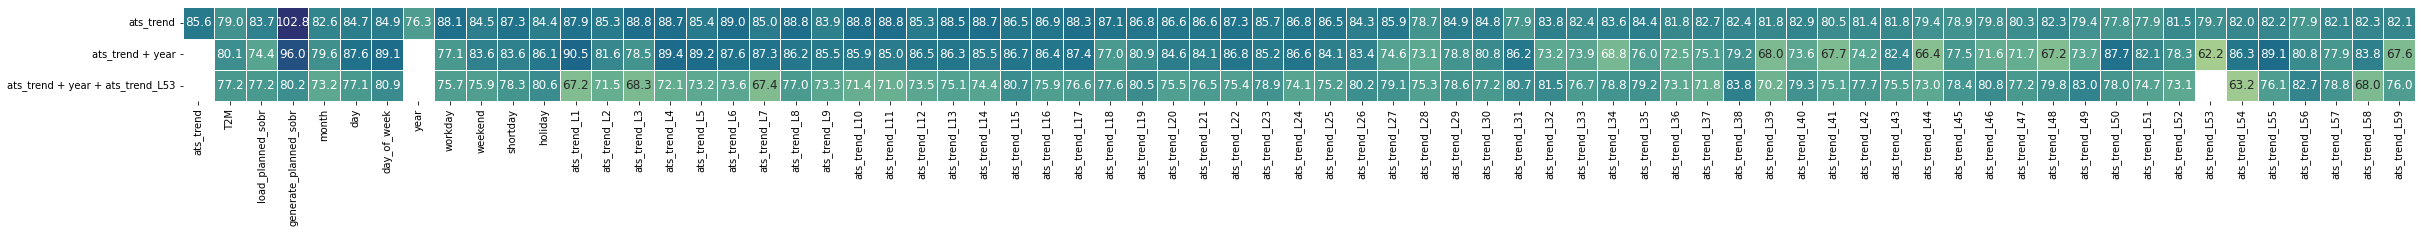

In [165]:
import seaborn as sns

plt.figure(figsize=(40, 20))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(results, cmap=cmap, square=True, linewidths=.5, cbar=False, annot=True, fmt=".1f", annot_kws={"size":12})